In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMG_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_CLASSES= 10
embed_size= 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [35]:
def gradient_penalty(critic, labels, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [36]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d,num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size= img_size
        self.disc= nn.Sequential(
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            self._block(features_d, features_d* 2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.embed= nn.Embedding(num_classes, img_size*img_size)
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias= False,
            ),
            nn.InstanceNorm2d(out_channels, affine= True),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x, labels):
        embedding= self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x= torch.cat([x, embedding], dim=1) 
        return self.disc(x)

In [37]:
class Generator(nn.Module):
    def __init__(
        self, 
        channels_noise, 
        channels_img, 
        features_g, 
        num_classes,
        img_size, 
        embed_size,
    ):
        super(Generator, self).__init__()
        self.img_size= img_size
        self.net= nn.Sequential(
            self._block(channels_noise+embed_size, features_g* 16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size= 4, stride= 2, padding=1
            ),
            nn.Tanh(),
        )
        self.embed= nn.Embedding(num_classes, embed_size)
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias= False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x, labels):
        embedding= self.embed(labels).unsqueeze(2).unsqueeze(3)
        x= torch.cat([x, embedding], dim=1)
        return self.net(x)

In [38]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [40]:
def test():
    N, in_channels, H, W= 8, 3, 64, 64
    noise_dim= 100
    num_classes= 10
    img_size= 64
    x= torch.randn((N, in_channels, H, W))
    labels= torch.randint(0, num_classes, (N,))
    disc= Discriminator(in_channels, 8, num_classes, img_size)
    assert disc(x, labels).shape== (N, 1, 1, 1), "Discriminator test Failed"
    
    gen= Generator(noise_dim, in_channels, 8, num_classes, img_size, embed_size)
    z= torch.randn((N, noise_dim, 1, 1))
    assert gen(z, labels).shape== (N, in_channels, H, W),"Generator test Failed"
    print("Success")
test()

Success


In [24]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [25]:
dataset = datasets.MNIST(root='dataset', train=True, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14447021.69it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 465521.56it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4393371.34it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2738325.25it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [41]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, embed_size).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMG_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [42]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
  (embed): Embedding(10, 4096

In [43]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, labels) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels= labels.to(device)
        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic,labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise, labels)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

 11%|█         | 101/938 [00:19<02:39,  5.26it/s]

Epoch [0/100] Batch 100/938                   Loss D: -108.1340, loss G: 67.6883


 22%|██▏       | 202/938 [00:36<02:10,  5.62it/s]

Epoch [0/100] Batch 200/938                   Loss D: -118.9960, loss G: 96.3102


 32%|███▏      | 302/938 [00:54<01:56,  5.46it/s]

Epoch [0/100] Batch 300/938                   Loss D: -115.5832, loss G: 111.0359


 43%|████▎     | 402/938 [01:11<01:39,  5.41it/s]

Epoch [0/100] Batch 400/938                   Loss D: -105.0663, loss G: 98.3104


 54%|█████▎    | 502/938 [01:29<01:18,  5.59it/s]

Epoch [0/100] Batch 500/938                   Loss D: -93.6249, loss G: 95.8102


 64%|██████▍   | 602/938 [01:46<00:59,  5.63it/s]

Epoch [0/100] Batch 600/938                   Loss D: -82.6631, loss G: 92.3803


 75%|███████▍  | 702/938 [02:04<00:41,  5.63it/s]

Epoch [0/100] Batch 700/938                   Loss D: -72.6156, loss G: 91.9290


 86%|████████▌ | 802/938 [02:21<00:24,  5.58it/s]

Epoch [0/100] Batch 800/938                   Loss D: -62.5357, loss G: 94.9299


 96%|█████████▌| 902/938 [02:39<00:06,  5.59it/s]

Epoch [0/100] Batch 900/938                   Loss D: -51.8332, loss G: 96.1501


 11%|█         | 102/938 [00:17<02:30,  5.56it/s]

Epoch [1/100] Batch 100/938                   Loss D: -40.2672, loss G: 95.4615


 22%|██▏       | 202/938 [00:35<02:13,  5.51it/s]

Epoch [1/100] Batch 200/938                   Loss D: -33.3004, loss G: 100.4335


 32%|███▏      | 302/938 [00:52<01:56,  5.46it/s]

Epoch [1/100] Batch 300/938                   Loss D: -25.6310, loss G: 101.5441


 43%|████▎     | 402/938 [01:10<01:35,  5.58it/s]

Epoch [1/100] Batch 400/938                   Loss D: -20.4272, loss G: 101.7357


 54%|█████▎    | 502/938 [01:27<01:17,  5.59it/s]

Epoch [1/100] Batch 500/938                   Loss D: -16.6736, loss G: 103.4125


 64%|██████▍   | 602/938 [01:45<00:59,  5.64it/s]

Epoch [1/100] Batch 600/938                   Loss D: -12.5123, loss G: 103.7683


 75%|███████▍  | 702/938 [02:02<00:42,  5.57it/s]

Epoch [1/100] Batch 700/938                   Loss D: -12.0308, loss G: 98.1772


 86%|████████▌ | 802/938 [02:20<00:24,  5.53it/s]

Epoch [1/100] Batch 800/938                   Loss D: -8.5179, loss G: 95.5379


 96%|█████████▌| 902/938 [02:37<00:06,  5.60it/s]

Epoch [1/100] Batch 900/938                   Loss D: -7.3887, loss G: 94.0514


  2%|▏         | 18/938 [00:03<02:47,  5.50it/s]


KeyboardInterrupt: 

In [44]:
def save_checkpoint(state, filename="CGANs.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [45]:
def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

In [46]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(images, title):
    # Create a grid from batch of images
    grid = vutils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()


In [53]:
def display_real_and_fake_images(generator, dataloader, device, num_images=32, z_dim=128):
    # Get a batch of real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_images].to(device)
    
     # Generate random labels for fake images
    random_labels = torch.randint(0, NUM_CLASSES, (num_images,)).to(device)

    # Generate fake images
    fixed_noise = torch.randn(num_images, z_dim, 1, 1).to(device)
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise, random_labels).detach().cpu()
    
    generator.train()

    # Display real images
    show_images(real_images, title="Real Images")

    # Display generated images
    show_images(fake_images, title="Generated Images")


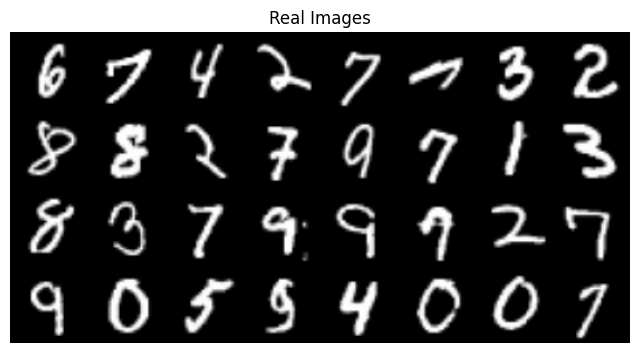

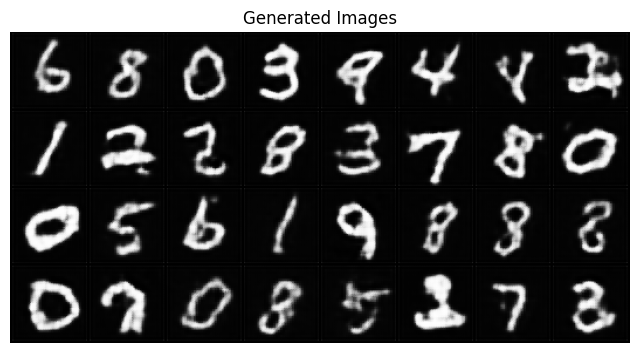

In [54]:
display_real_and_fake_images(gen, loader, device, num_images=32, z_dim=Z_DIM)